This notebooks produces some plots associated with the paper produced with this repository. It creates the optimization plots related to the altitude analysis.

---
Author: Jordi Grau Escolano


# 1. Load data

In [2]:
import os, sys, pickle, warnings
from pathlib import Path as PathLib

import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
from shapely import unary_union
from shapely.ops import split
from shapely.geometry import Point, LineString

import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import Rectangle
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize,ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import MatplotlibDeprecationWarning
import seaborn as sns
import contextily as ctx

warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)

# Add project root to path
project_root = PathLib().resolve().parents[0]
sys.path.insert(0, str(project_root))

from paths import *
import src.data_loader as dl
import src.optimization.experiments.helper_experiment as he
import src.optimization.helper_optimization as ho
import src.results_exploration.helper_visualizations as hv
import src.optimization.experiments.graph_metrics.alpha_screening.alpha_screening_plot as asp

ROOT = "../"

# Load data
df, G, distance_matrix, id_to_idx, idx_to_id, _, STATION_MIN_DISTANCE = he.load_data(root=ROOT)
city_boundary = dl.load_bcn_boundary()

# Define scenarios
weights_dict = {
    "s1": {"population": 0.4, "pois_total": 0.35, "pois_entropy": 0.25},
    "s2": {"bus_lines": 0.2, "metro_lines": 0.2, "tram_lines": 0.1, "pois_total": 0.4, "bike_lane_kms": 0.1},
    "s3": {"income_2022_pers": 0.4, "unemployment": 0.3, "education_primary": 0.3}
}

# Check scenario weights sum to 1
for s in weights_dict:
    print(f"scenario={s} -> {sum(weights_dict[s].values())}")

# Compute normalized scores
df_weights = pd.DataFrame()
for s in weights_dict:
    if df_weights.empty:
        df_weights = ho.sum_and_normalize_all_node_scores(df, weights_dict[s])
        df_weights.rename(columns={'norm_score': s}, inplace=True)
    else:
        df_weights[s] = ho.sum_and_normalize_all_node_scores(df, weights_dict[s])['norm_score']


RESULTS_DIR = f'{ROOT}/{VISUALIZATIONS}/scenarios/altitude'
os.makedirs(RESULTS_DIR, exist_ok=True)

df_weights.head(2)

	Successfully loaded graph bike_graph with protocol 5
Loading existing node attributes from ..//data/processed/nodes/node_attributes.csv
Loading pre-computed distance matrix and mappings...
	Successfully loaded mappings with protocol 5
Successfully loaded distance matrix of shape (18721, 18721)
scenario=s1 -> 1.0
scenario=s2 -> 1.0
scenario=s3 -> 1.0


income_2022_pers  household_avg_m2  altitude  has_bike_lane  \
node_id                                                                   
21638831                0.64              0.68      2.09              0   
1259351831              0.66              0.71      2.68              0   

            bike_lane_kms  n_health_care  n_culture  n_tourism  n_recreation  \
node_id                                                                        
21638831              0.0            0.0       0.14       0.22          0.12   
1259351831            0.0            0.0       0.00       0.00          0.00   

            n_sport  ...  motos_abs  cars_abs  others_abs  \
node_id              ...                                    
21638831        0.0  ...        0.0       0.0        3.22   
1259351831      0.0  ...        0.0       0.0        0.00   

            non_spanish_population  unemployment_percentage  \
node_id                                                       
21638831                      0.04                     0.67   
1259351831                    0.00                     0.68   

                                  geometry   score        s1        s2  \
node_id                                                                  
21638831    POINT (431665.633 4579427.183)  0.1925  0.240175  0.147952   
1259351831   POINT (431577.21 4579241.901)  0.0790  0.098565  0.100396   

                  s3  
node_id               
21638831    0.277778  
1259351831  0.256667  

[2 rows x 48 columns]

In [3]:
# Load optimization results
results_file = '/home/data/processed/experiments/scenarios/no_graph_metrics.csv'
df_results = pd.read_csv(results_file)
df_results['best_solution'] = df_results['best_solution'].apply(lambda x: eval(x))
df_results['weights'] = df_results['weights'].apply(lambda x: {k.split(': ')[0]: float(k.split(': ')[1]) for k in eval(x)})

# Stations for each scenario
results_dict = {
    'stations': {s: df_results[df_results['weights'] == w]['best_solution'].values[0] 
                if len(df_results[df_results['weights'] == w]) > 0 else []
                for s,w in weights_dict.items()},
    'weights': weights_dict
}

# Get data for one scenario
def get_data_for_one_scenario(scenario, df_weights=df_weights, results_dict=results_dict):
    weights = results_dict['weights'][scenario]
    stations = results_dict['stations'][scenario]
    df_data = df_weights[df_weights.index.isin(stations)]
    return weights, stations, df_data


# Variables to plot and their string replacements
vars = ["population", "pois_total", "pois_entropy", 
        "bus_lines", "metro_lines", "tram_lines", 
        "income_2022_pers", "unemployment", "education_primary", "bike_lane_kms"]

N = len(vars)

string_replace = {
    'population': 'pop',
    'pois_total': 'pois_count',
    'pois_entropy': 'pois_div',
    'bus_lines': 'bus',
    'bike_lane_kms': 'lanes',
    'metro_lines': 'metro',
    'tram_lines': 'tram',
    'income_2022_pers': 'income',
    'unemployment': 'unemp',
    'education_primary': 'edu',
}

In [4]:
# Load optimization results
df_results = f'{ROOT}/{PR_EXP}/scenarios/alpha_screening.csv'
df_results = pd.read_csv(df_results)
df_results['best_solution'] = df_results['best_solution'].apply(lambda x: eval(x))
df_results['weights'] = df_results['weights'].apply(lambda x: {k.split(': ')[0]: float(k.split(': ')[1]) for k in eval(x)})
df_results.drop([
    'experiment_idx', 'N_stations', 'minutes_to_complete', 'generations',
    'score_combination', 'penalty_power'], axis=1, inplace=True)

# Fill NaN values with scenario names
for scenario in ['s1', 's2', 's3']:
    df_results.loc[(df_results['alpha'].isna())
                   & (df_results['weights'] == weights_dict[scenario]), 'alpha'] = scenario.upper()

# Initialize dictionaries to store results for each scenario
alpha_scenarios = {scenario: {} for scenario in ['s1', 's2', 's3']}

# Process data for each scenario
for scenario in ['s1', 's2', 's3']:
    # Filter for specific scenario weights
    scenario_results = df_results[df_results['weights'] == weights_dict[scenario]].copy()
    # Sort results by alpha and calculate scenario values
    sorted_alphas = sorted(scenario_results['alpha'].astype(str).unique())
    for alpha in sorted_alphas:
        # Get stations for this alpha
        stations = scenario_results.loc[scenario_results['alpha'].astype(str) == alpha, 'best_solution'].iloc[0]
        
        # Calculate scenario values for these stations
        scenario_utility_vals = df_weights.loc[stations, scenario]
        scenario_input_vals = df_weights.loc[stations, vars]
        alpha_scenarios[scenario][alpha] = {
            'utility_vals': np.asarray(scenario_utility_vals),
            'means': {var: np.asarray(scenario_input_vals[var].mean()) for var in vars},
            'stds': {var: np.asarray(scenario_input_vals[var].std()) for var in vars},
            'all_values': {var: scenario_input_vals[var].values for var in vars}
        }
        
        # Print summary
        print(f"{scenario} α={alpha} → total {scenario} = {scenario_utility_vals.sum():.3f}")


s1 α=0.0 → total s1 = 215.711
s1 α=0.25 → total s1 = 219.648
s1 α=0.5 → total s1 = 219.989
s1 α=0.75 → total s1 = 222.255
s1 α=1.0 → total s1 = 223.764
s1 α=S1 → total s1 = 224.641
s2 α=0.0 → total s2 = 182.359
s2 α=0.25 → total s2 = 185.243
s2 α=0.5 → total s2 = 187.881
s2 α=0.75 → total s2 = 187.435
s2 α=1.0 → total s2 = 190.312
s2 α=S2 → total s2 = 190.501
s3 α=0.0 → total s3 = 181.427
s3 α=0.25 → total s3 = 186.096
s3 α=0.5 → total s3 = 188.613
s3 α=0.75 → total s3 = 189.343
s3 α=1.0 → total s3 = 189.982
s3 α=S3 → total s3 = 194.387


/tmp/ipykernel_7157/1862570175.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'S1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_results.loc[(df_results['alpha'].isna())


In [5]:
# Compute bounds for stations
normalization_bounds = asp.compute_bounds_for_stations(
    G, distance_matrix, id_to_idx, idx_to_id, 
    [len(df_results['best_solution'].values[0])], 
    min_distance=300)

min_disp, max_disp, min_acc, max_acc = normalization_bounds[250]
disp_bounds = (min_disp, max_disp)
acc_bounds = (min_acc, max_acc)

In [6]:
# Load Barcelona's altitude data to plot the altitude contours
df_altitude = pd.read_csv(f'{ROOT}/{PR_INPUT}/topology_altitude_slope_50.csv')
df_altitude = gpd.GeoDataFrame(df_altitude, geometry=gpd.points_from_xy(df_altitude['longitude'], df_altitude['latitude']), crs=4326)
df_altitude = df_altitude.to_crs(25831)

# Drop rows without altitude
df_altitude = df_altitude.clip(city_boundary.geometry.total_bounds)
df_altitude = df_altitude.dropna(subset=['altitude'])
df_altitude.loc[df_altitude['altitude'] < 0, 'altitude'] = 0

# Extract coordinates and altitude
lons = df_altitude['geometry'].x
lats = df_altitude['geometry'].y
alts = df_altitude['altitude'].values

df_altitude.head(2)

latitude  longitude  altitude  avg_slope  max_slope  \
35485  41.358197   2.185448       0.0        0.0        0.0   
37442  41.360458   2.186346       0.0        0.0        0.0   

                             geometry  
35485   POINT (431866.825 4578841.58)  
37442  POINT (431944.322 4579091.955)

In [7]:
# Load results with altitude optimization
results_file = '/home/data/processed/experiments/scenarios/alpha_screening_altitude.csv'
df_results_alt = pd.read_csv(results_file)
df_results_alt['best_solution'] = df_results_alt['best_solution'].apply(lambda x: eval(x))
df_results_alt['weights'] = df_results_alt['weights'].apply(lambda x: {k.split(': ')[0]: float(k.split(': ')[1]) for k in eval(x)})

# Fill NaN values with scenario names
for scenario in ['s1', 's2', 's3']:
    df_results_alt.loc[(df_results_alt['alpha'].isna())
                   & (df_results_alt['weights'] == weights_dict[scenario]), 'alpha'] = scenario.upper()

df_results_alt.head(2)

/tmp/ipykernel_7157/3916982952.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'S1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_results_alt.loc[(df_results_alt['alpha'].isna())


experiment_idx  N_stations alpha  best_score  minutes_to_complete  \
0               7         250    S3  195.897778            78.018373   
1               9         250    S1  225.037430            50.670066   

   generations                                            weights  \
0         2060  {'income_2022_pers': 0.4, 'unemployment': 0.3,...   
1         1290  {'population': 0.4, 'pois_total': 0.35, 'pois_...   

                                       best_solution score_combination  \
0  [30227460, 7042287287, 30884341, 7042385451, 7...          multiply   
1  [30227460, 209062087, 824497176, 30884341, 704...          multiply   

   penalty_power  
0            NaN  
1            NaN

In [8]:
file_name = f'{ROOT}/{RAW_GRAPH}/bike_graph_elevation.pickle'
with open(file_name, 'rb') as f:
    G = pickle.load(f)

nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)
edges_gdf = edges_gdf[['geometry', 'weight', 'elevation', 'weight_parkin']]
edges_gdf['slope'] = (edges_gdf['elevation'] / edges_gdf['weight']) * 100
edges_gdf.head()

geometry  \
u          v          key                                                      
21638831   1259351831 0    LINESTRING (431665.633 4579427.183, 431603.993...   
           8972696444 0    LINESTRING (431665.633 4579427.183, 431678.212...   
1259351831 30317502   0    LINESTRING (431577.21 4579241.901, 431567.963 ...   
           21638831   0    LINESTRING (431577.21 4579241.901, 431584.341 ...   
           1259351650 0    LINESTRING (431577.21 4579241.901, 431570.693 ...   

                               weight  elevation  weight_parkin      slope  
u          v          key                                                   
21638831   1259351831 0    205.509259       0.59     209.514582   0.287092  
           8972696444 0     49.264265       0.02      49.397804   0.040597  
1259351831 30317502   0     19.591276       0.62      24.822100   3.164674  
           21638831   0    205.509259      -0.59     203.200044  -0.287092  
           1259351650 0     17.412892       3.06      32.615932  17.573187

# 2. Altitude




## 2.1. General analysis 


Distance: 
             weight  weight_parkin
count  39116.000000   39116.000000
mean      70.931842      78.808425
std       83.003612      99.791635
min        0.033481       0.033481
25%       16.987725      18.188715
50%       48.427429      51.051851
75%       97.233231     105.871330
max     1257.438678    1891.087568


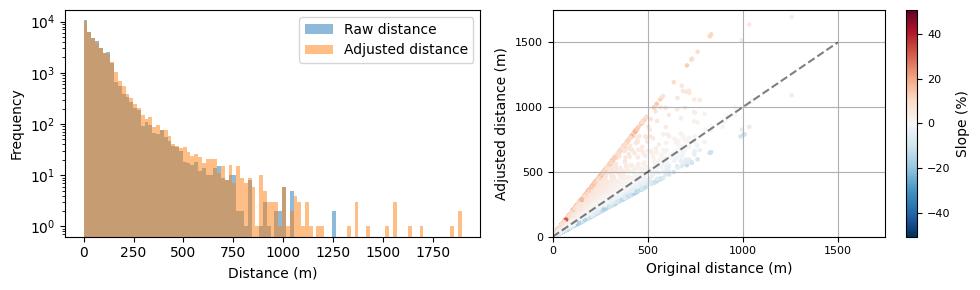

In [9]:
def plot_distance_histogram(edges_gdf, ax, fontsize=8):
    bins = np.linspace(0, edges_gdf['weight_parkin'].max(), 100)
    ax.hist(edges_gdf['weight'], bins=bins, alpha=0.5, label='Raw distance')
    ax.hist(edges_gdf['weight_parkin'], bins=bins, alpha=0.5, label='Adjusted distance')
    ax.set_xlabel('Distance (m)')
    ax.set_ylabel('Frequency')
    ax.set_yscale('log')
    ax.legend()
    
    print(f"\nDistance: \n{edges_gdf[['weight', 'weight_parkin']].describe()}")

def plot_distance_comparison(edges_gdf, ax, ticks_spacing, fontsize):
    scatter = ax.scatter(edges_gdf['weight'], edges_gdf['weight_parkin'],
                      c=edges_gdf['slope'], alpha=1, s=5,
                      cmap='RdBu_r', norm=plt.Normalize(vmin=-edges_gdf['slope'].abs().max(),
                                                    vmax=edges_gdf['slope'].abs().max()))

    # Diagonal line
    ax.plot([0, 1500], [0, 1500], 'k--', alpha=0.5)
    ax.set_xlim(0, 1750)
    ax.set_ylim(0, 1750)

    ax.set_ylabel('Adjusted distance (m)')
    ax.set_xlabel('Original distance (m)')
    ax.grid(True)
    ax.set_xticks(np.arange(0, 1751, ticks_spacing))
    ax.set_yticks(np.arange(0, 1751, ticks_spacing))
    ax.tick_params(axis='both', labelsize=fontsize)

    # Add colorbar
    cbar = plt.colorbar(scatter, label='Slope (%)')
    cbar.ax.tick_params(labelsize=fontsize)

# Create and show plots
fig, axs = plt.subplots(1,2,figsize=(10, 3))
plot_distance_histogram(edges_gdf, axs[0])
plot_distance_comparison(edges_gdf, axs[1], ticks_spacing=500, fontsize=8)
plt.tight_layout()
plt.show()

In [10]:
def filter_stations_data(df_results, df_weights, weights_dict, scenario):
    # Get the results for this scenario
    df_results_scenario = df_results[(df_results['weights'] == weights_dict[scenario])]
    
    # Get the stations for this scenario
    results = {}
    for alpha in df_results_scenario['alpha'].unique():
        if alpha not in ['S1', 'S2', 'S3', 0, 1]: continue
        df_results_scenario_alpha = df_results_scenario[df_results_scenario['alpha'] == alpha]
        station_sc = df_results_scenario_alpha['best_solution'].values[0]
        df_sc = df_weights[df_weights.index.isin(station_sc)]
        results[alpha] = df_sc
    return results


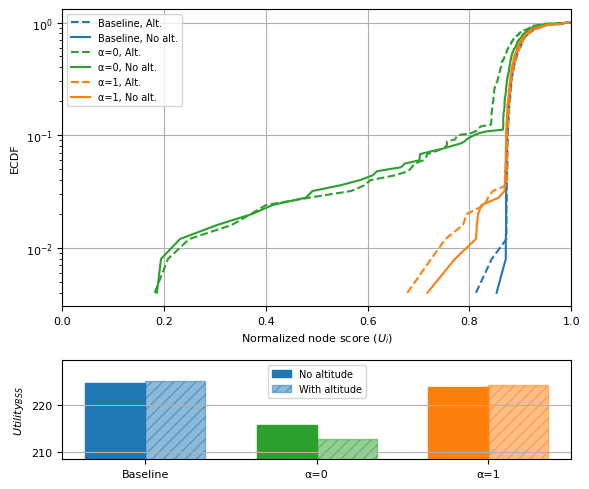

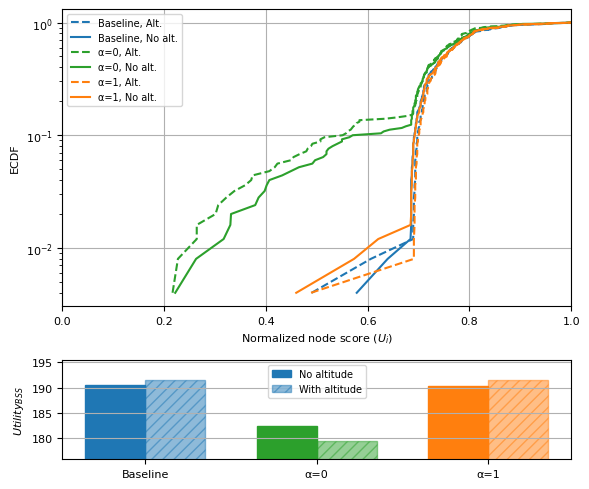

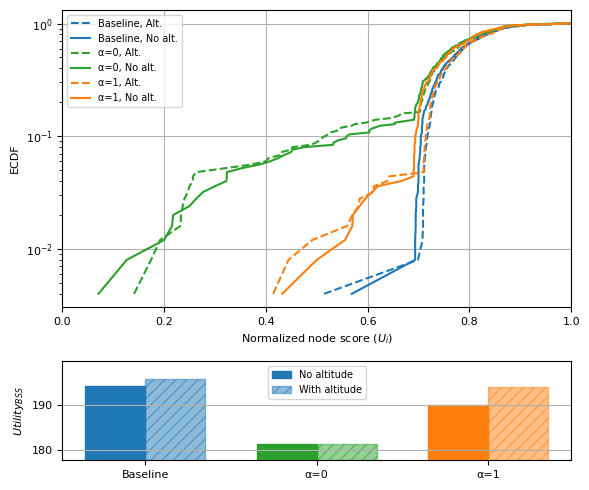

In [11]:
def create_ecdf_plot(ax, ecdfs, color_dict, fontsize):
    """Create ECDF plot with combined legend."""
    # Sort ecdfs to ensure scenarios (S1,S2,S3) come before alpha values
    def sort_key(x):
        alpha = x[0][0]
        is_scenario = str(alpha).startswith('S')
        # Sort by: scenarios first (False), then alpha value, then altitude type
        return (not is_scenario, str(alpha), x[0][1] != 'With altitude')
        
    sorted_ecdfs = sorted(ecdfs.items(), key=sort_key)

    alt_string_replacer = {
        'No altitude': 'No alt.',
        'With altitude': 'Alt.'
    }

    for (alpha, altitude_type), (x,y) in sorted_ecdfs:
        color = color_dict[str(alpha).lower() if alpha != str(scenario).upper() else scenario]
        linestyle = '-' if altitude_type == 'No altitude' else '--'

        if str(alpha).replace('.','').isdigit():
            if float(alpha).is_integer():
                label = f'α={int(float(alpha))}, {alt_string_replacer[altitude_type]}'
            else:
                label = f'α={float(alpha)}, {alt_string_replacer[altitude_type]}'
        else:
            label = f'Baseline, {alt_string_replacer[altitude_type]}'

        ax.plot(x, y, linestyle=linestyle, color=color, label=label)

    ax.legend(fontsize=fontsize-1, loc='upper left')
    ax.set_ylabel('ECDF', fontsize=fontsize)
    ax.set_xlabel('Normalized node score ($U_i$)', fontsize=fontsize)
    ax.grid(True)
    ax.set_xlim(0, 1)
    ax.tick_params(axis='both', labelsize=fontsize)
    ax.set_yscale('log')

def create_bar_plot(ax, totals, color_dict, fontsize):
    """Create grouped bar plot comparing altitude vs no altitude."""
    # Get unique alphas and reorder them
    alphas = list(set(alpha for alpha, _ in totals.keys()))
    scenario_alpha = next(a for a in alphas if str(a).lower() == scenario)
    other_alphas = sorted([a for a in alphas if str(a).lower() != scenario])
    alphas = [scenario_alpha] + other_alphas
    
    x = np.arange(len(alphas))
    width = 0.35
    patterns = ['', '///']

    for i, altitude_type in enumerate(['No altitude', 'With altitude']):
        bar_x = x - width/2 if i == 0 else x + width/2
        heights = [totals.get((alpha, altitude_type), 0) for alpha in alphas]
        alpha = 1 if altitude_type == 'No altitude' else 0.5
        
        bars = ax.bar(bar_x, heights, width, label=altitude_type, alpha=alpha)
        
        for j, bar in enumerate(bars):
            color = color_dict[str(alphas[j]).lower() if alphas[j] != str(scenario).upper() else scenario]
            bar.set_color(color)
            bar.set_hatch(patterns[i])

    ax.set_xticks(x)
    # Format x-axis labels based on alpha values:
    # - For integer alphas (e.g. 1.0), show as 'α=1'
    # - For decimal alphas (e.g. 0.5), show as 'α=0.5' 
    # - For non-numeric alphas (e.g. 'S1'), show as is
    labels = []
    for alpha in alphas:
        if str(alpha).replace('.','').isdigit():
            if float(alpha).is_integer():
                labels.append(f'α={int(float(alpha))}')
            else:
                labels.append(f'α={float(alpha)}')
        else:
            labels.append("Baseline")
    ax.set_xticklabels(labels, fontsize=fontsize)
    ax.set_ylabel('$Utility_{BSS}$', fontsize=fontsize)
    ax.grid(True, axis='y')
    ax.legend(fontsize=fontsize-1)
    ax.tick_params(axis='both', labelsize=fontsize)
    
    all_sums = list(totals.values())
    ax.set_ylim(min(all_sums)*0.98, max(all_sums)*1.02)

def process_scenario_data(scenario, df_results, df_results_alt, df_weights, weights_dict):
    """Process data for both altitude and non-altitude cases."""
    ecdfs = {}
    totals = {}
    
    for altitude_type in ['No altitude', 'With altitude']:
        df = df_results if altitude_type == 'No altitude' else df_results_alt
        stations_data_dict = filter_stations_data(df, df_weights, weights_dict, scenario)
        sorted_items = sorted(stations_data_dict.items(), 
                            key=lambda x: (x[0] != scenario.upper(), x[0]))
        
        for alpha, data in sorted_items:
            x = np.sort(data[scenario])
            y = np.arange(1, len(x)+1) / len(x)
            label = scenario.upper() if alpha == scenario.upper() else str(alpha)
            key = (label, altitude_type)
            ecdfs[key] = (x, y)
            totals[key] = data[scenario].sum()
            
    return ecdfs, totals

fontsize = 8

# Define colors for different alpha values
color_dict = {
    '0.0': '#2ca02c',    # Default matplotlib green  
    '1.0': '#ff7f0e',    # Default matplotlib orange
}

# Plot for each scenario
for scenario in ['s1', 's2', 's3']:
    color_dict[scenario] = '#1f77b4'  # Add scenario color
    
    # Create figure
    fig, (ax_ecdf, ax_bar) = plt.subplots(2, 1, figsize=(6,5), height_ratios=[3,1])
    
    # Process data
    ecdfs, totals = process_scenario_data(scenario, df_results, df_results_alt, 
                                        df_weights, weights_dict)
    
    # Create plots
    create_ecdf_plot(ax_ecdf, ecdfs, color_dict, fontsize)
    create_bar_plot(ax_bar, totals, color_dict, fontsize)

    plt.tight_layout()
    plt.show()
    
    del color_dict[scenario]  # Clean up for next iteration

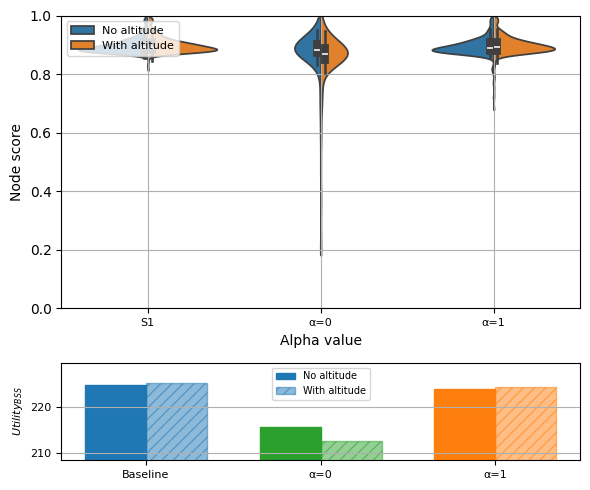

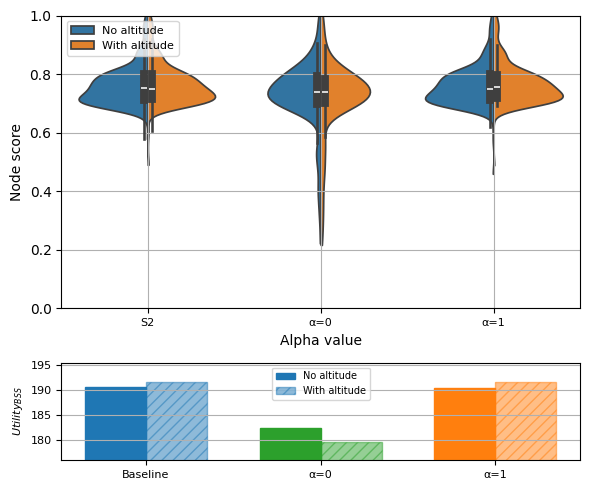

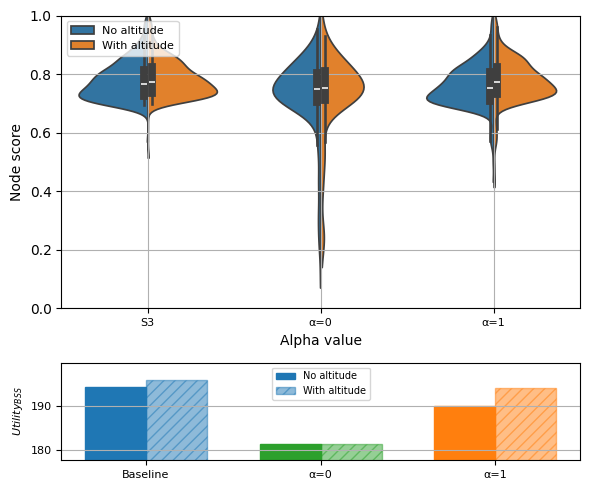

In [12]:
def create_violin_plot(ax, ecdfs, color_dict, fontsize):
    """Create split violin plot comparing altitude vs no altitude."""
    # Get unique alphas and reorder them
    alphas = list(set(alpha for alpha, _ in totals.keys()))
    scenario_alpha = next(a for a in alphas if str(a).lower() == scenario)
    other_alphas = sorted([a for a in alphas if str(a).lower() != scenario])
    alphas = [scenario_alpha] + other_alphas
    # Prepare data for violin plot
    data = []
    for (alpha, altitude_type), (x,y) in ecdfs.items():
        data.extend([(score, alpha, altitude_type) for score in x])
    
    df_violin = pd.DataFrame(data, columns=['Score', 'Alpha', 'Type'])
    
    # Create split violin plot
    vplot = sns.violinplot(data=df_violin, x='Alpha', y='Score', hue='Type', 
                  split=True, inner='box', cut=0, ax=ax)

    # Update colors and patterns to match bar plot
    for i, violin in enumerate(vplot.collections[::2]):
        alpha = violin.get_label()
        try:
            color = color_dict[str(alpha).lower() if alpha != str(scenario).upper() else scenario]
        except:
            print(f"Warning: Color not found for alpha={alpha}")
            continue
        
        # Left side (No altitude)
        violin.set_facecolor(color)
        violin.set_alpha(1.0)
        violin.set_hatch('')
        
        # Right side (With altitude)
        violin_right = vplot.collections[i*2 + 1]
        violin_right.set_facecolor(color)
        violin_right.set_alpha(0.5)
        violin_right.set_hatch('///')

    ax.legend(fontsize=fontsize, loc='upper left')
    ax.set_ylabel('Node score')
    ax.set_xlabel('Alpha value')
    ax.set_xticks(np.arange(len(alphas)))
    labels = []
    for alpha in alphas:
        if str(alpha).replace('.','').isdigit():
            if float(alpha).is_integer():
                labels.append(f'α={int(float(alpha))}')
            else:
                labels.append(f'α={float(alpha)}')
        else:
            labels.append(str(alpha))
    ax.set_xticklabels(labels, fontsize=fontsize)
    
    ax.grid(True)
    ax.set_ylim(0, 1)

def process_scenario_data(scenario, df_results, df_results_alt, df_weights, weights_dict):
    """Process data for both altitude and non-altitude cases."""
    ecdfs = {}
    totals = {}
    
    for altitude_type in ['No altitude', 'With altitude']:
        df = df_results if altitude_type == 'No altitude' else df_results_alt
        stations_data_dict = filter_stations_data(df, df_weights, weights_dict, scenario)
        sorted_items = sorted(stations_data_dict.items(), 
                            key=lambda x: (x[0] != scenario.upper(), x[0]))
        
        for alpha, data in sorted_items:
            x = np.sort(data[scenario])
            y = np.arange(1, len(x)+1) / len(x)
            label = scenario.upper() if alpha == scenario.upper() else str(alpha)
            key = (label, altitude_type)
            ecdfs[key] = (x, y)
            totals[key] = data[scenario].sum()
            
    return ecdfs, totals

fontsize = 8

# Define colors for different alpha values
color_dict = {
    '0.0': '#2ca02c',    # Default matplotlib green  
    '1.0': '#ff7f0e',    # Default matplotlib orange
}

# Plot for each scenario
for scenario in ['s1', 's2', 's3']:
    color_dict[scenario] = '#1f77b4'  # Add scenario color
    
    # Create figure
    fig, (ax_ecdf, ax_bar) = plt.subplots(2, 1, figsize=(6,5), height_ratios=[3,1])
    
    # Process data
    ecdfs, totals = process_scenario_data(scenario, df_results, df_results_alt, 
                                        df_weights, weights_dict)
    
    # Create plots
    create_violin_plot(ax_ecdf, ecdfs, color_dict, fontsize)
    create_bar_plot(ax_bar, totals, color_dict, fontsize)

    plt.tight_layout()
    plt.show()
    
    del color_dict[scenario]  # Clean up for next iteration

## 2.2. Topography maps with stations

In [14]:
def plot_altitude_contours(ax, lons, lats, alts, city_boundary, background_map=True, attribution=False, attribution_size=8, altitude_granularity=50, back_resolution=12):
    """Plot altitude contours on a map with city boundary clipping.
    
    Args:
        ax: Matplotlib axis to plot on
        lons: x-coordinates of altitude points
        lats: y-coordinates of altitude points 
        alts: altitude values
        city_boundary: GeoDataFrame with city boundary
        altitude_granularity: Spacing between contour levels in meters
    """
    # Get city boundary bounds and add buffer
    bounds = city_boundary.geometry.total_bounds
    buffer = 100 
    bounds_buffered = [
        bounds[0],  # minx
        bounds[1] - buffer,  # miny 
        bounds[2],  # maxx
        bounds[3] + buffer   # maxy
    ]
    
    min_alt, max_alt = alts.min(), alts.max()
    levels = np.arange(np.floor(min_alt), np.ceil(max_alt), altitude_granularity)
    
    lines = ax.tricontour(
        lons, lats, alts, levels=levels, cmap='terrain', 
        linewidths=0.5, linestyles='dashed')
    ax.clabel(lines, inline=True, fontsize=8, fmt='%d m', colors='gray',
              levels=np.arange(np.floor(min_alt), np.ceil(max_alt), 100))

    if background_map:
        ctx.add_basemap(
            ax, source=ctx.providers.CartoDB.Positron, crs=city_boundary.crs, zoom=back_resolution, 
            attribution=attribution, attribution_size=attribution_size)

    # Set axis limits to buffered bounds
    ax.set_xlim(bounds_buffered[0], bounds_buffered[2])
    ax.set_ylim(bounds_buffered[1], bounds_buffered[3])

    # Clip contours to city boundary
    city_poly = unary_union(city_boundary.geometry)
    city_border = city_poly.boundary

    for coll in lines.collections:
        new_paths = []

        for path in coll.get_paths():
            verts = path.vertices
            codes = path.codes

            split_idxs = np.where(codes == Path.MOVETO)[0].tolist() + [len(verts)]
            
            for i in range(len(split_idxs)-1):
                start, end = split_idxs[i], split_idxs[i+1]
                segment_verts = verts[start:end]
                if len(segment_verts) < 2:
                    continue

                seg_line = LineString(segment_verts)
                clipped = split(seg_line, city_border)
                
                for piece in clipped.geoms:
                    if piece.is_empty:
                        continue
                    mid = piece.interpolate(0.5, normalized=True)
                    if not city_poly.contains(mid):
                        continue

                    pc = np.array(piece.coords)
                    codes_new = [Path.MOVETO] + [Path.LINETO]*(len(pc)-1)
                    new_paths.append(Path(pc, codes_new))

        coll.set_paths(new_paths)

    # Draw city boundary
    city_boundary.boundary.plot(ax=ax, edgecolor='black', linewidth=1.5)
    
    ax.set_axis_off()

In [15]:
def plot_rectangle(ax, x1, x2, y1, y2, number=1):
    """Plot a rectangle on the given axis using the provided coordinates.
    
    Args:
        ax: matplotlib axis
        x1: longitude of first point (EPSG:4326)
        x2: longitude of second point (EPSG:4326)
        y1: latitude of first point (EPSG:4326)
        y2: latitude of second point (EPSG:4326)
        number: number to display in top right corner (default: 1)
    """
    # Convert coordinates from EPSG:4326 to EPSG:25831
    points = gpd.GeoDataFrame(
        geometry=[Point(x1, y1), Point(x2, y2)],
        crs="EPSG:4326").to_crs("EPSG:25831")
    
    # Extract transformed coordinates
    x1_t, x2_t = points.geometry.x.values
    y1_t, y2_t = points.geometry.y.values
    
    # Calculate rectangle dimensions
    rect_width = x2_t - x1_t
    rect_height = y2_t - y1_t
    
    # Add rectangle patch
    ax.add_patch(Rectangle((x1_t, y1_t), rect_width, rect_height,
                          fill=False, edgecolor='black', 
                          linewidth=1, linestyle=':'))
    
    # Add number in top left corner
    ax.text(x1_t+75, y2_t-100, str(number),
            horizontalalignment='left', 
            verticalalignment='top',
            fontsize=10)
    
    # ax.set_xlim(bounds_buffered[0], bounds_buffered[2])
    # ax.set_ylim(bounds_buffered[1], bounds_buffered[3])


In [14]:
def plot_stations_in_rectangles(stations_gdf, scenario,ax, rectangle, city_boundary):
    """Filters and plots stations in rectangle on a map.
    
    Args:
        stations_gdf: GeoDataFrame containing station points
        ax: Matplotlib axis to plot on
        rectangle: Tuple of (x1, x2, y1, y2) for rectangle
        city_boundary: GeoDataFrame with city boundary
    """
    # Convert rectangle coordinates from EPSG:4326 to EPSG:25831
    points = gpd.GeoDataFrame(
        geometry=[Point(rectangle[0], rectangle[2]), Point(rectangle[1], rectangle[3])],
        crs="EPSG:4326").to_crs("EPSG:25831")
    
    # Extract transformed coordinates
    x1, x2 = points.geometry.x.values
    y1, y2 = points.geometry.y.values

    # Filter stations in rectangle using transformed coordinates
    stations_in_rect = stations_gdf[
        (stations_gdf.geometry.x > x1) & 
        (stations_gdf.geometry.x < x2) &
        (stations_gdf.geometry.y > y1) &
        (stations_gdf.geometry.y < y2)
    ]

    ax.text(x1+75, y1+75, f"n={len(stations_in_rect)}", 
            horizontalalignment='left',
            verticalalignment='bottom',
            fontsize=10)

    # Plot stations in rectangle
    ax.scatter(stations_in_rect.geometry.x, stations_in_rect.geometry.y, 
              c=stations_in_rect[scenario], cmap='viridis_r', s=5, vmin=0, vmax=1)

    # Add city boundary
    city_boundary.boundary.plot(ax=ax, edgecolor='black', linewidth=1.5)
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=city_boundary.crs, zoom=14, attribution=False)
    
    # Set axis limits to transformed bounds
    ax.set_xlim(x1, x2)
    ax.set_ylim(y1, y2)

    return ax

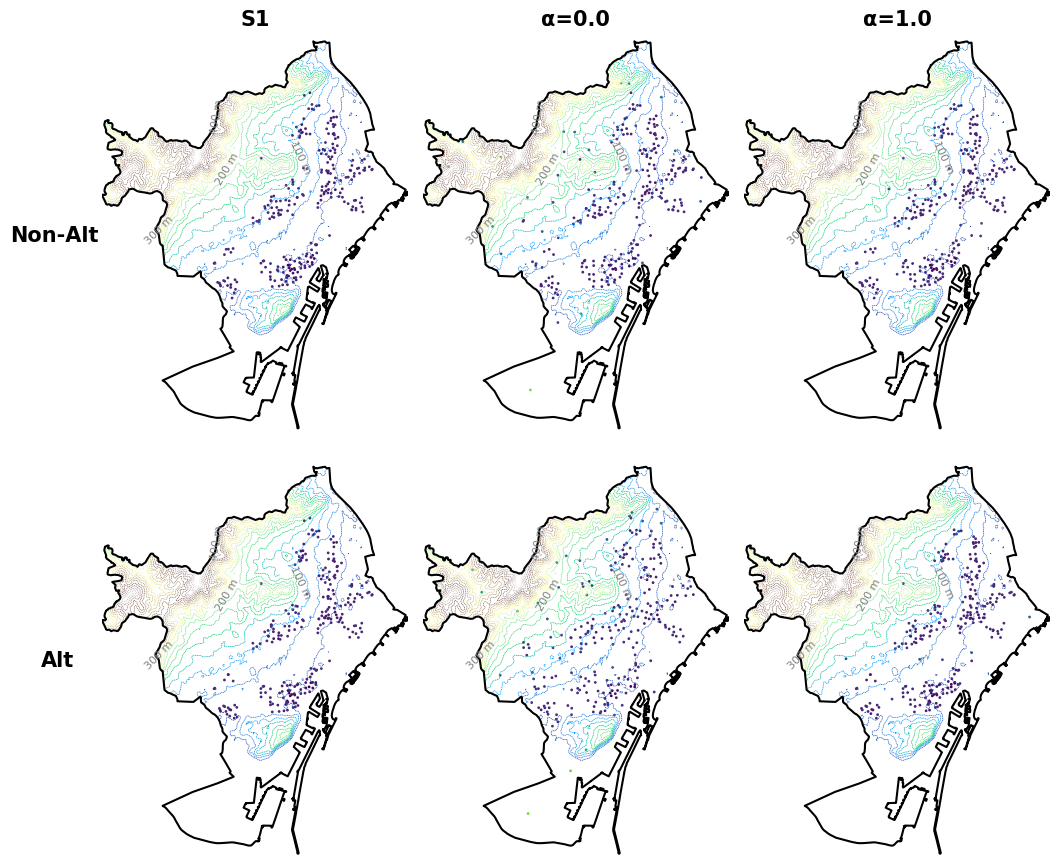

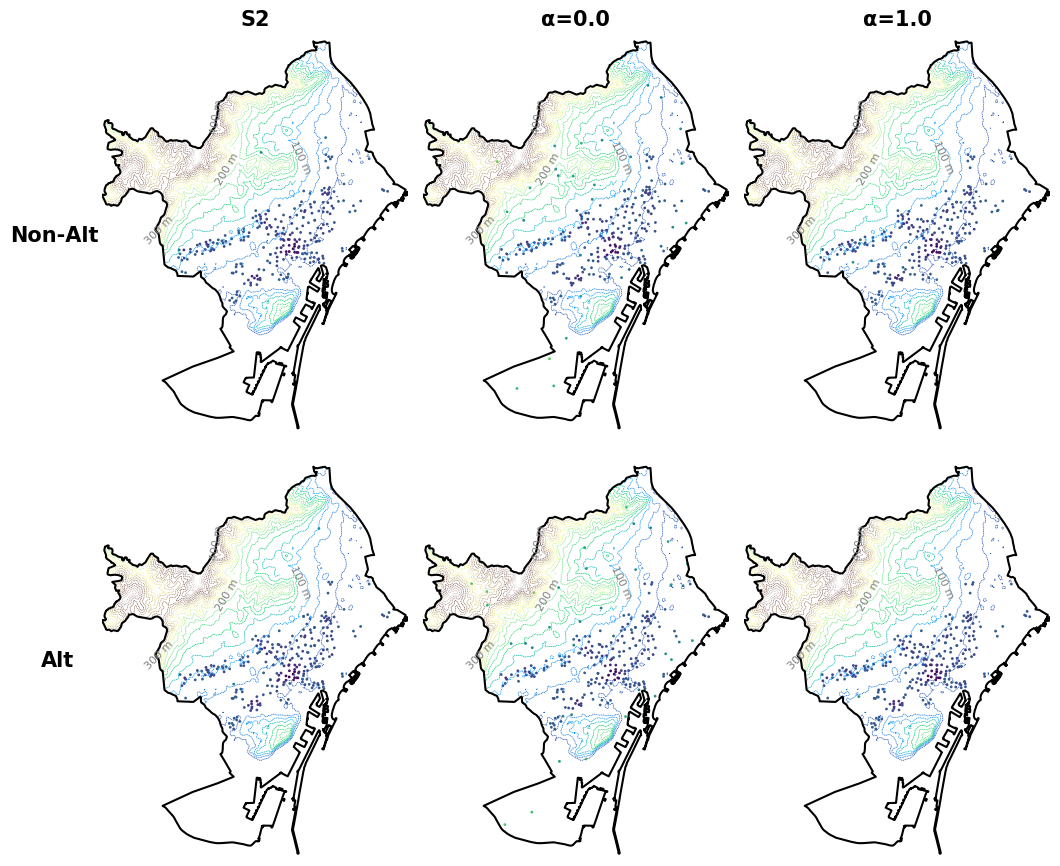

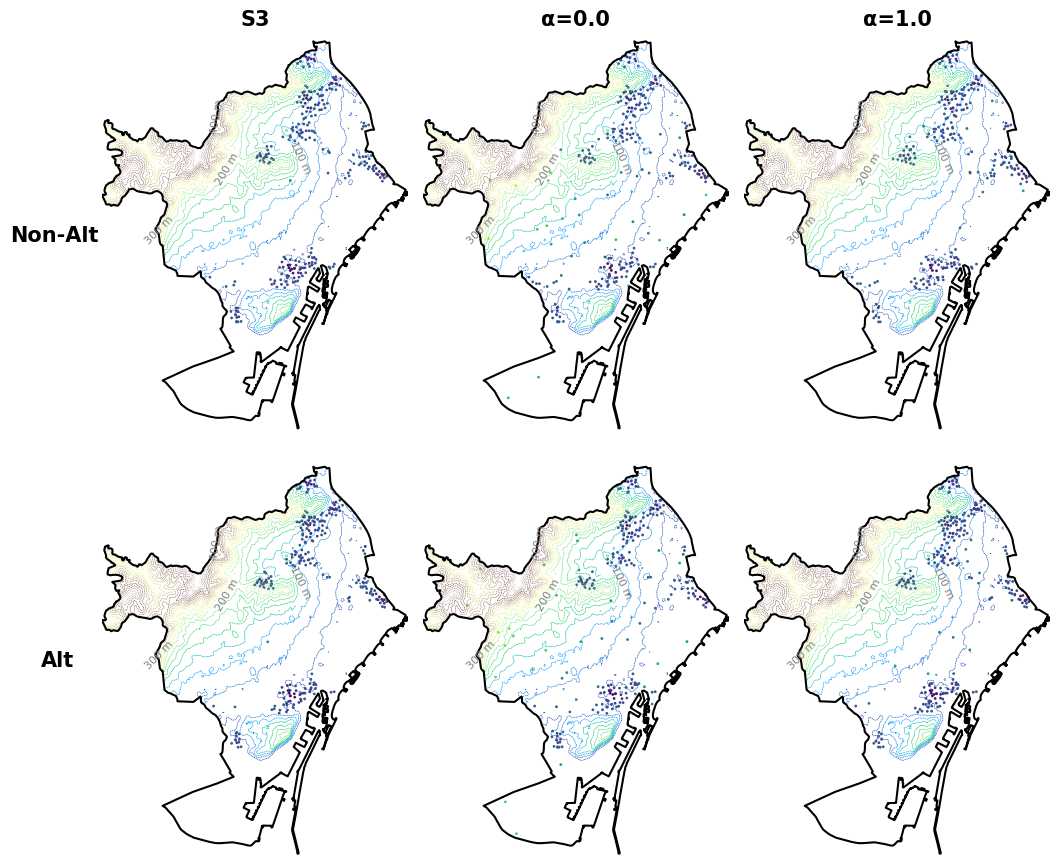

In [16]:
# Plot all stations on map
alpha_order = ['S1', '0.0', '1.0']
for scenario in ['s1', 's2', 's3']:
    alpha_order[0] = scenario.upper()  # Replace S1 with scenario name
    stations_data_dict = filter_stations_data(df_results, df_weights, weights_dict, scenario)
    stations_data_alt_dict = filter_stations_data(df_results_alt, df_weights, weights_dict, scenario)

    fig, axs = plt.subplots(2, len(alpha_order), figsize=(len(alpha_order)*3.5, 9))
    axs = axs.flatten()

    # Titles
    for i, alpha in enumerate(alpha_order):
        axs[i].set_title(f'α={float(alpha)}' if alpha not in ['S1', 'S2', 'S3'] else alpha, pad=10, fontsize=15, fontweight='bold')
    axs[0].text(-0.3, 0.5, 'Non-Alt', transform=axs[0].transAxes, fontsize=15, fontweight='bold', va='center')
    axs[len(alpha_order)].text(-0.2, 0.5, 'Alt', transform=axs[len(alpha_order)].transAxes, fontsize=15, fontweight='bold', va='center')

    # Plot for each alpha
    for col, alpha in enumerate(alpha_order):
        alpha = float(alpha) if alpha not in ['S1', 'S2', 'S3'] else alpha
        attribution = col == 0 or col + len(alpha_order) == 3

        # Plot altitude contours
        plot_altitude_contours(axs[col], lons, lats, alts, city_boundary, background_map=False, altitude_granularity=25)
        plot_altitude_contours(axs[col + len(alpha_order)], lons, lats, alts, city_boundary, background_map=False, altitude_granularity=25)

        # Plot stations
        if alpha in stations_data_dict:
            axs[col].scatter(stations_data_dict[alpha].geometry.x, stations_data_dict[alpha].geometry.y,
                           c=stations_data_dict[alpha][scenario], cmap='viridis_r', vmin=0, vmax=1, s=1)
        if alpha in stations_data_alt_dict:
            axs[col + len(alpha_order)].scatter(stations_data_alt_dict[alpha].geometry.x, stations_data_alt_dict[alpha].geometry.y,
                                              c=stations_data_alt_dict[alpha][scenario], cmap='viridis_r', vmin=0, vmax=1, s=1)

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_7157/1927147428.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


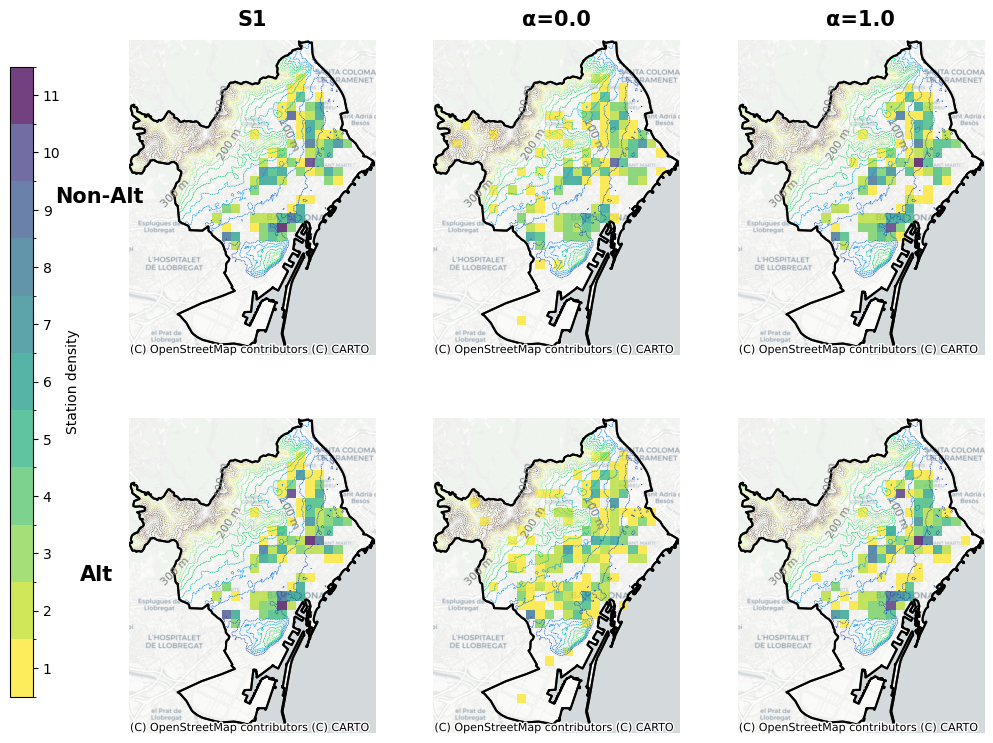

/tmp/ipykernel_7157/1927147428.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


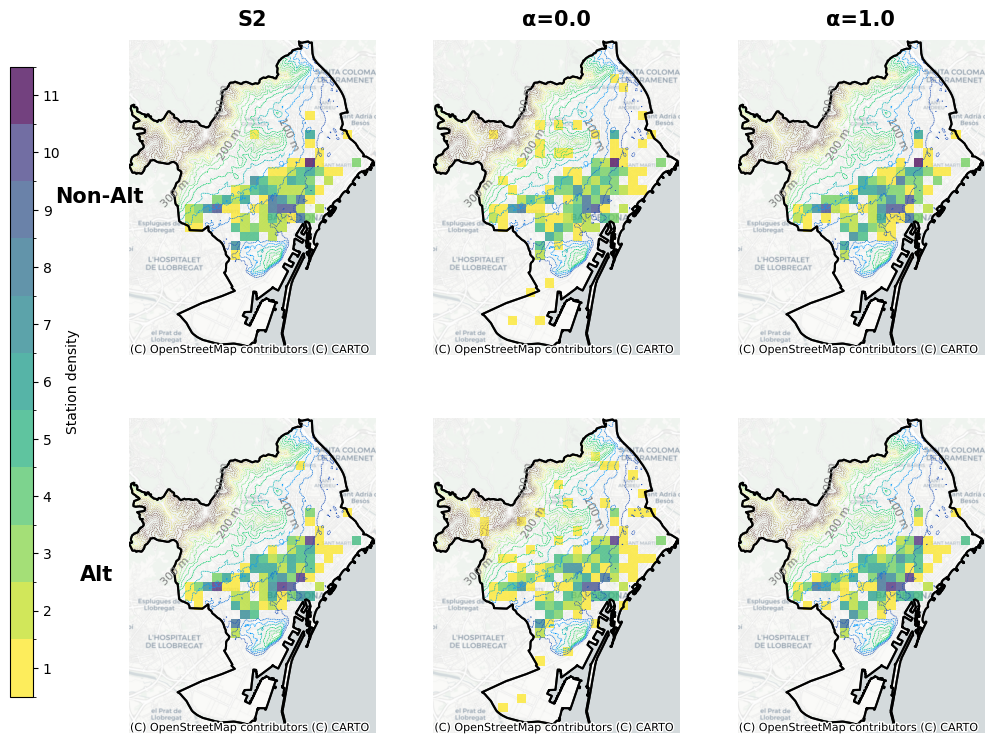

/tmp/ipykernel_7157/1927147428.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


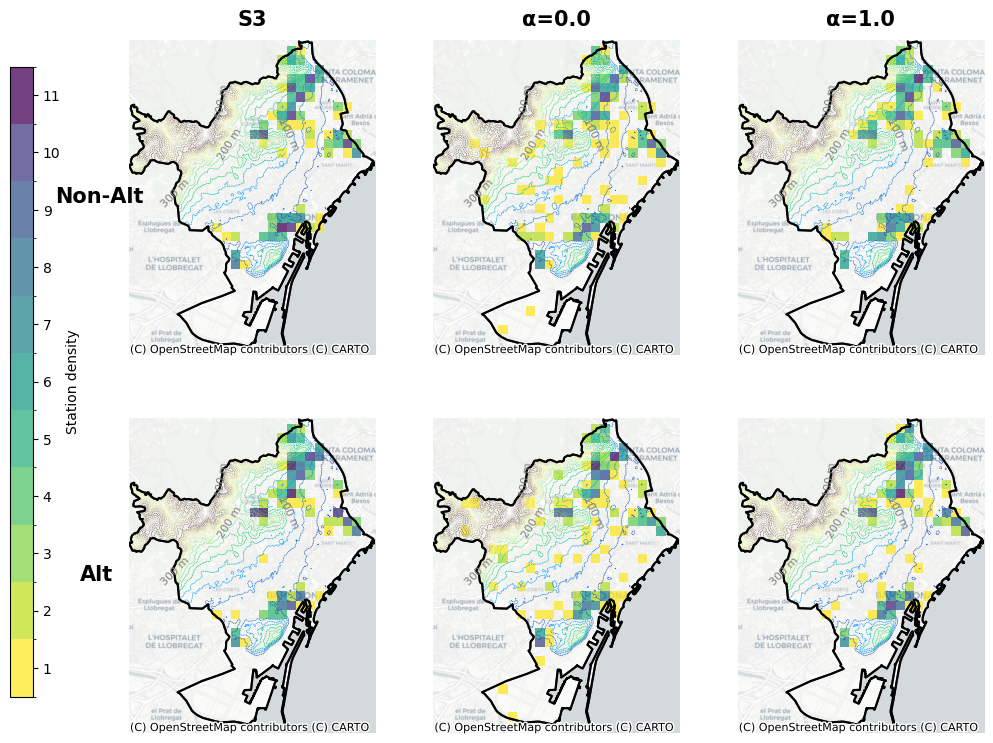

In [17]:
# Plot all stations on grid map
grid_size = 500

alpha_order = ['S1', '0.0', '1.0']
for scenario in ['s1', 's2', 's3']:
    alpha_order[0] = scenario.upper()  # Replace S1 with scenario name
    stations_data_dict = filter_stations_data(df_results, df_weights, weights_dict, scenario)
    stations_data_alt_dict = filter_stations_data(df_results_alt, df_weights, weights_dict, scenario)

    # Create figure with extra space on left for colorbar
    fig = plt.figure(figsize=(len(alpha_order)*3.5 + 1, 9))
    gs = fig.add_gridspec(2, len(alpha_order), left=0.15)  # Add padding on left
    axs = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(len(alpha_order))]

    # Titles
    for i, alpha in enumerate(alpha_order):
        axs[i].set_title(f'α={float(alpha)}' if alpha not in ['S1', 'S2', 'S3'] else alpha, pad=10, fontsize=15, fontweight='bold')
    axs[0].text(-0.3, 0.5, 'Non-Alt', transform=axs[0].transAxes, fontsize=15, fontweight='bold', va='center')
    axs[len(alpha_order)].text(-0.2, 0.5, 'Alt', transform=axs[len(alpha_order)].transAxes, fontsize=15, fontweight='bold', va='center')

    # Calculate global min/max values for consistent color scale
    all_grid_counts = []
    for alpha in alpha_order:
        alpha_val = float(alpha) if alpha not in ['S1', 'S2', 'S3'] else alpha
        if alpha_val in stations_data_dict:
            grid_cells = hv.create_grid_cells_and_count_points(city_boundary, stations_data_dict[alpha_val], 500)
            all_grid_counts.extend(grid_cells['n_points'].tolist())
        if alpha_val in stations_data_alt_dict:
            grid_cells = hv.create_grid_cells_and_count_points(city_boundary, stations_data_alt_dict[alpha_val], 500)
            all_grid_counts.extend(grid_cells['n_points'].tolist())
    vmin, vmax = min(all_grid_counts) if all_grid_counts else 0, max(all_grid_counts) if all_grid_counts else 1

    # Create a colorbar axes on the left
    cbar_ax = fig.add_axes((0.05, 0.15, 0.02, 0.7))

    # Create discrete colormap
    n_bins = int(vmax) + 1
    colors = plt.cm.viridis_r(np.linspace(0, 1, n_bins))
    colors = [(c[0], c[1], c[2], 0.75) for c in colors]  # Set alpha to 0.75
    cmap = plt.cm.colors.ListedColormap(colors)
    bounds = np.arange(1, n_bins + 1)  # Start from 1 instead of 0
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

    # Create a dummy mappable for the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Plot for each alpha
    for col, alpha in enumerate(alpha_order):
        alpha = float(alpha) if alpha not in ['S1', 'S2', 'S3'] else alpha
        attribution = col == 0 or col + len(alpha_order) == 3

        # Plot altitude contours
        plot_altitude_contours(axs[col], lons, lats, alts, city_boundary, background_map=False, altitude_granularity=25)
        plot_altitude_contours(axs[col + len(alpha_order)], lons, lats, alts, city_boundary, background_map=False, altitude_granularity=25)

        # Plot stations
        if alpha in stations_data_dict:
            grid_cells = hv.plot_grid_cells_on_map(
                city_boundary, stations_data_dict[alpha], grid_size=grid_size, 
                ax=axs[col], show_colorbar=False, vmin=vmin, vmax=vmax)
        if alpha in stations_data_alt_dict:
            grid_cells = hv.plot_grid_cells_on_map(
                city_boundary, stations_data_alt_dict[alpha], grid_size=grid_size, 
                ax=axs[col + len(alpha_order)], show_colorbar=False, vmin=vmin, vmax=vmax)

    # Add colorbar using the dummy mappable
    plt.colorbar(sm, cax=cbar_ax, label='Station density', ticks=bounds[:-1] + 0.5)
    cbar_ax.set_yticklabels([str(int(i)) for i in bounds[:-1]])

    plt.tight_layout()
    plt.show()

alpha S1 max_diff_global
alpha 0.0 max_diff_global
alpha 1.0 max_diff_global
alpha S1
stations_data_dict dict_keys([0.0, 1.0, 'S1'])
stations_data_alt_dict dict_keys(['S1', 0.0, 1.0])
alpha 0.0
stations_data_dict dict_keys([0.0, 1.0, 'S1'])
stations_data_alt_dict dict_keys(['S1', 0.0, 1.0])
alpha 1.0
stations_data_dict dict_keys([0.0, 1.0, 'S1'])
stations_data_alt_dict dict_keys(['S1', 0.0, 1.0])


/tmp/ipykernel_7157/605166752.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


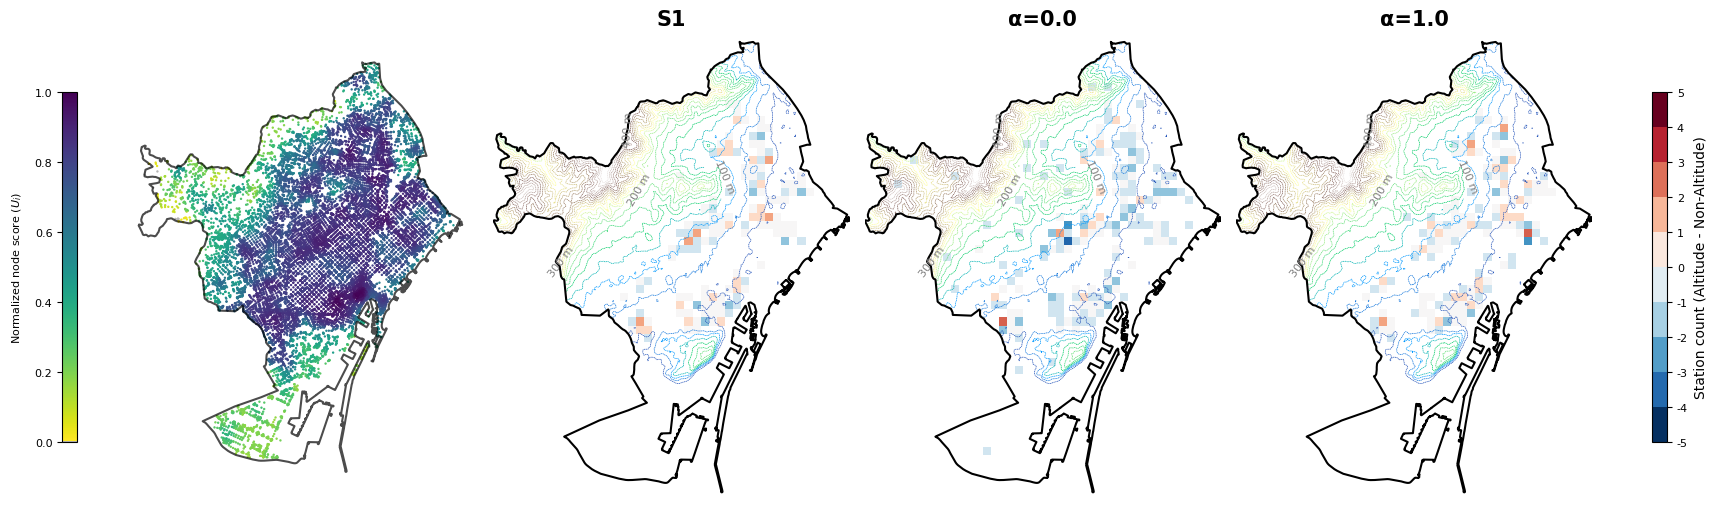

alpha S2 max_diff_global
alpha 0.0 max_diff_global
alpha 1.0 max_diff_global
alpha S2
stations_data_dict dict_keys([0.0, 1.0, 'S2'])
stations_data_alt_dict dict_keys(['S2', 0.0, 1.0])
alpha 0.0
stations_data_dict dict_keys([0.0, 1.0, 'S2'])
stations_data_alt_dict dict_keys(['S2', 0.0, 1.0])
alpha 1.0
stations_data_dict dict_keys([0.0, 1.0, 'S2'])
stations_data_alt_dict dict_keys(['S2', 0.0, 1.0])


/tmp/ipykernel_7157/605166752.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


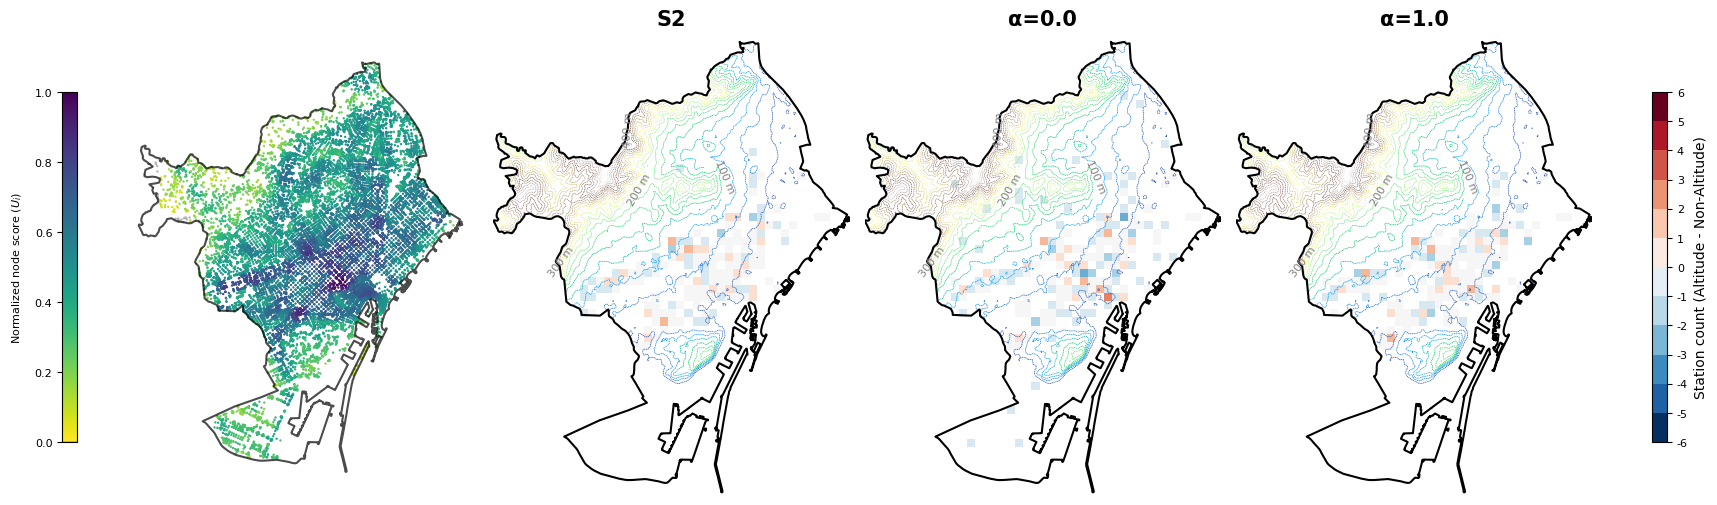

alpha S3 max_diff_global
alpha 0.0 max_diff_global
alpha 1.0 max_diff_global
alpha S3
stations_data_dict dict_keys([0.0, 'S3', 1.0])
stations_data_alt_dict dict_keys(['S3', 0.0, 1.0])
alpha 0.0
stations_data_dict dict_keys([0.0, 'S3', 1.0])
stations_data_alt_dict dict_keys(['S3', 0.0, 1.0])
alpha 1.0
stations_data_dict dict_keys([0.0, 'S3', 1.0])
stations_data_alt_dict dict_keys(['S3', 0.0, 1.0])


/tmp/ipykernel_7157/605166752.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


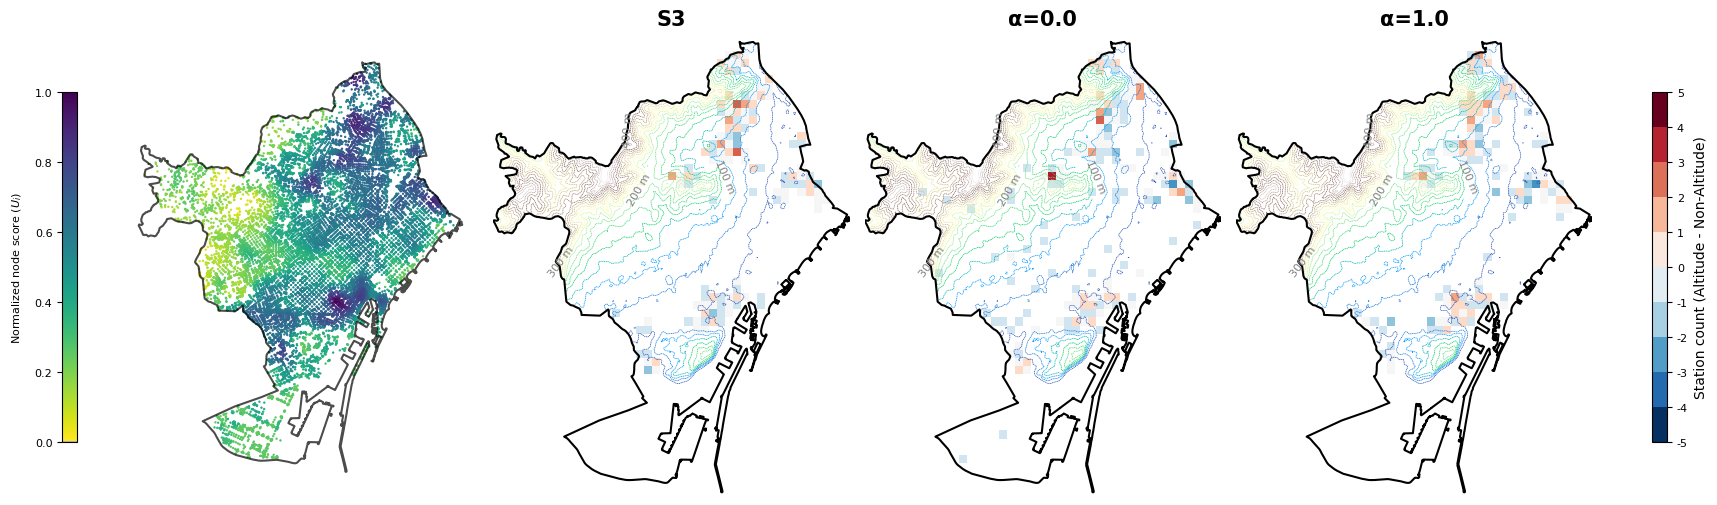

In [18]:
def create_node_scores_colorbar(fig):
    """Create and configure colorbar for node scores"""
    cax = fig.add_axes((-0.03, 0.15, 0.01, 0.7))
    
    # Create custom colormap with gray for zero values
    viridis_r = plt.get_cmap('viridis_r')
    colors = [(0.7, 0.7, 0.7, 1.0)]  # Start with gray
    colors.extend(viridis_r(np.linspace(0, 1, 255)))
    custom_cmap = ListedColormap(colors)
    norm = Normalize(vmin=0, vmax=1)

    sm = ScalarMappable(norm=norm, cmap=custom_cmap)
    cbar = plt.colorbar(sm, cax=cax, location='left')
    cbar.set_label('Normalized node score ($U_i$)', fontsize=8, labelpad=8)
    cax.tick_params(labelsize=8)
    cax.yaxis.set_ticks_position('left')
    cax.yaxis.set_label_position('left')

def plot_station_differences(ax, stations_data_dict, stations_data_alt_dict, alpha, city_boundary, grid_size, max_diff_global, diff_cmap):
    """Plot station count differences between altitude and non-altitude cases"""
    print("alpha", alpha)
    print("stations_data_dict", stations_data_dict.keys())
    print("stations_data_alt_dict", stations_data_alt_dict.keys())

    if alpha not in stations_data_dict or alpha not in stations_data_alt_dict:
        return
        
    # Get grid cells for both cases
    grid_cells_non_alt = hv.create_grid_cells_and_count_points(city_boundary, stations_data_dict[alpha], grid_size)
    grid_cells_alt = hv.create_grid_cells_and_count_points(city_boundary, stations_data_alt_dict[alpha], grid_size)
    
    # Merge on geometry and fill missing values with 0
    grid_cells_non_alt = grid_cells_non_alt.set_index(grid_cells_non_alt.geometry.apply(lambda x: x.wkt))
    grid_cells_alt = grid_cells_alt.set_index(grid_cells_alt.geometry.apply(lambda x: x.wkt))
    
    # Get union of all grid cell geometries
    all_geometries = set(grid_cells_non_alt.index) | set(grid_cells_alt.index)
    
    # Fill missing values with 0 for both dataframes
    for geom in all_geometries:
        if geom not in grid_cells_non_alt.index:
            grid_cells_non_alt.loc[geom, 'n_points'] = 0
        if geom not in grid_cells_alt.index:
            grid_cells_alt.loc[geom, 'n_points'] = 0
    
    # Calculate and plot differences
    diff = grid_cells_alt['n_points'] - grid_cells_non_alt['n_points']
    grid_cells_diff = grid_cells_non_alt.copy()
    grid_cells_diff['n_points'] = diff
    
    grid_cells_diff.plot(
        column='n_points',
        cmap=diff_cmap,
        ax=ax,
        alpha=1,
        legend=False,
        vmin=-max_diff_global,
        vmax=max_diff_global
    )

def create_difference_colorbar(fig, max_diff_global, diff_cmap):
    """Create colorbar for station count differences"""
    cbar_ax_diff = fig.add_axes((1.03, 0.15, 0.01, 0.7))
    bounds = np.arange(-max_diff_global, max_diff_global + 1)
    norm_diff = mpl.colors.BoundaryNorm(bounds, diff_cmap.N)
    sm_diff = plt.cm.ScalarMappable(cmap=diff_cmap, norm=norm_diff)
    cbar_diff = plt.colorbar(sm_diff, cax=cbar_ax_diff, 
                           label='Station count (Altitude - Non-Altitude)',
                           ticks=bounds, format='%d', alpha=1)
    cbar_diff.ax.tick_params(labelsize=8)

# Main plotting loop
grid_size = 300
altitude_granularity = 25
alpha_order = ['S1', '0.0', '1.0']

for scenario in ['s1', 's2', 's3']:
    alpha_order[0] = scenario.upper()

    # Setup figure and axes
    fig = plt.figure(figsize=(len(alpha_order)*3.5 + 4.5, 5))
    gs = fig.add_gridspec(1, len(alpha_order) + 1)
    axs = [fig.add_subplot(gs[0, j]) for j in range(len(alpha_order) + 1)]

    # Plot node scores and colorbar
    hv.plot_nodes_on_map(df_weights, scenario.lower(), axs[0], city_boundary, 
                        show_colorbar=False, show_norm_raw_vals=False, ctx_background=False)
    create_node_scores_colorbar(fig)

    # Get stations data
    stations_data_dict = filter_stations_data(df_results, df_weights, weights_dict, scenario)
    stations_data_alt_dict = filter_stations_data(df_results_alt, df_weights, weights_dict, scenario)

    # Set subplot titles
    for i, alpha in enumerate(alpha_order):
        axs[i+1].set_title(f'α={float(alpha)}' if alpha not in ['S1', 'S2', 'S3'] else alpha, 
                          pad=10, fontsize=15, fontweight='bold')
    
    # Setup difference colormap
    diff_cmap = plt.cm.RdBu_r
    
    # Calculate max difference for consistent scale
    max_diff_global = 0
    for alpha in alpha_order:
        alpha = float(alpha) if alpha not in ['S1', 'S2', 'S3'] else alpha
        if alpha in stations_data_dict and alpha in stations_data_alt_dict:
            grid_non_alt = hv.create_grid_cells_and_count_points(city_boundary, stations_data_dict[alpha], grid_size)
            grid_alt = hv.create_grid_cells_and_count_points(city_boundary, stations_data_alt_dict[alpha], grid_size)
            
            # Merge on geometry and fill missing values with 0
            grid_non_alt = grid_non_alt.set_index(grid_non_alt.geometry.apply(lambda x: x.wkt))
            grid_alt = grid_alt.set_index(grid_alt.geometry.apply(lambda x: x.wkt))
            
            # Get union of all grid cell geometries
            all_geometries = set(grid_non_alt.index) | set(grid_alt.index)
            
            # Fill missing values with 0
            for geom in all_geometries:
                if geom not in grid_non_alt.index:
                    grid_non_alt.loc[geom, 'n_points'] = 0
                if geom not in grid_alt.index:
                    grid_alt.loc[geom, 'n_points'] = 0
            
            diff = grid_alt['n_points'].values - grid_non_alt['n_points'].values
            max_diff_global = max(max_diff_global, abs(diff).max())
            print("alpha", alpha, "max_diff_global")


    # Plot differences for each alpha
    for col, alpha in enumerate(alpha_order):
        alpha = float(alpha) if alpha not in ['S1', 'S2', 'S3'] else alpha
        plot_altitude_contours(axs[col+1], lons, lats, alts, city_boundary, 
                             background_map=False, altitude_granularity=altitude_granularity)
        plot_station_differences(axs[col+1], stations_data_dict, stations_data_alt_dict, 
                               alpha, city_boundary, grid_size, max_diff_global, diff_cmap)

    create_difference_colorbar(fig, max_diff_global, diff_cmap)
    plt.tight_layout()
    plt.show()

# 3. Create final full figure

In [19]:
def create_figure():
    # Create figure with complex subplot layout
    fig = plt.figure(figsize=(12, 10))

    # Create GridSpec for the entire figure
    gs = GridSpec(2, 6, height_ratios=[1, 1.5], figure=fig)

    # First row - 2 subplots with second one split vertically
    ax_scatter = fig.add_subplot(gs[0, 0:2])  # Left subplot takes 2 columns

    # Split the second subplot into two vertically with more spacing
    gs_right = GridSpec(2, 1, height_ratios=[3, 2], hspace=0.5)  
    gs_right.update(left=0.47, right=0.95, top=0.88, bottom=0.58)  
    ax_ecdf = fig.add_subplot(gs_right[0])  # Top of split subplot (3/5)
    ax_bar = fig.add_subplot(gs_right[1])  # Bottom of split subplot (2/5)

    # Second row - 4 subplots with space for colorbars
    gs_bottom = GridSpec(1, 4, width_ratios=[0.7, 1, 1, 1], wspace=0.07)
    gs_bottom.update(top=0.7, bottom=-0.05, left=0.1, right=0.95)
    ax_map_node_scores = fig.add_subplot(gs_bottom[0, 0])  # Bottom left subplot
    ax_map_scenario = fig.add_subplot(gs_bottom[0, 1])  # Bottom middle-left subplot 
    ax_map_alpha_0 = fig.add_subplot(gs_bottom[0, 2])  # Bottom middle-right subplot
    ax_map_alpha_1 = fig.add_subplot(gs_bottom[0, 3])  # Bottom right subplot

    axes_first_row = [ax_scatter, ax_ecdf, ax_bar]
    axes_second_row = [ax_map_node_scores, ax_map_scenario, ax_map_alpha_0, ax_map_alpha_1]

    return fig, axes_first_row, axes_second_row

In [20]:
def create_node_scores_colorbar(ax, fontsize):
    """Create and configure colorbar for node scores"""
    # Create custom colormap with gray for zero values
    viridis_r = plt.get_cmap('viridis_r')
    colors = [(0.7, 0.7, 0.7, 1.0)]  # Start with gray
    colors.extend(viridis_r(np.linspace(0, 1, 255)))
    custom_cmap = ListedColormap(colors)
    norm = Normalize(vmin=0, vmax=1)

    # Get position and dimensions of the ax
    pos = ax.get_position()
    cbar_ax = ax.figure.add_axes([pos.x0 - 0.185, pos.y0*1.5, 0.01, pos.height*0.5])

    sm = ScalarMappable(norm=norm, cmap=custom_cmap)
    cbar = plt.colorbar(sm, cax=cbar_ax, aspect=50)  # Higher aspect ratio makes the colorbar thinner
    cbar.set_label('Normalized node score ($U_i$)', fontsize=fontsize, labelpad=8)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.ax.yaxis.set_ticks_position('left')
    cbar.ax.yaxis.set_label_position('left')

def create_difference_colorbar(fig, max_diff_global, diff_cmap, fontsize):
    """Create colorbar for station count differences"""
    cbar_ax_diff = fig.add_axes((0.98, 0.175, 0.013, 0.3))
    bounds = np.arange(-max_diff_global, max_diff_global + 1)
    norm_diff = mpl.colors.BoundaryNorm(bounds, diff_cmap.N)
    sm_diff = plt.cm.ScalarMappable(cmap=diff_cmap, norm=norm_diff)
    cbar_diff = plt.colorbar(sm_diff, cax=cbar_ax_diff, 
                           label='Station count (Altitude - Non-Altitude)',
                           ticks=bounds, format='%d', alpha=1)
    cbar_diff.ax.tick_params(labelsize=fontsize)

alpha S1
stations_data_dict dict_keys([0.0, 1.0, 'S1'])
stations_data_alt_dict dict_keys(['S1', 0.0, 1.0])
alpha 0.0
stations_data_dict dict_keys([0.0, 1.0, 'S1'])
stations_data_alt_dict dict_keys(['S1', 0.0, 1.0])
alpha 1.0
stations_data_dict dict_keys([0.0, 1.0, 'S1'])
stations_data_alt_dict dict_keys(['S1', 0.0, 1.0])


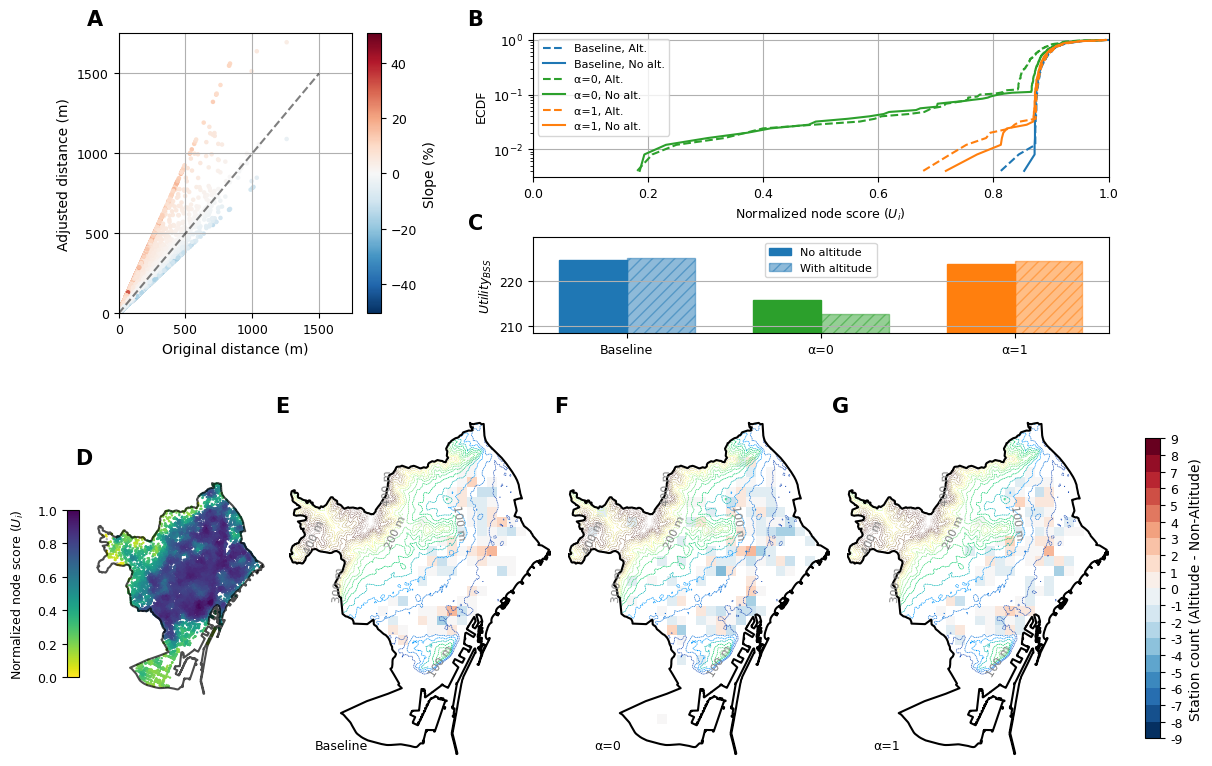

alpha S2
stations_data_dict dict_keys([0.0, 1.0, 'S2'])
stations_data_alt_dict dict_keys(['S2', 0.0, 1.0])
alpha 0.0
stations_data_dict dict_keys([0.0, 1.0, 'S2'])
stations_data_alt_dict dict_keys(['S2', 0.0, 1.0])
alpha 1.0
stations_data_dict dict_keys([0.0, 1.0, 'S2'])
stations_data_alt_dict dict_keys(['S2', 0.0, 1.0])


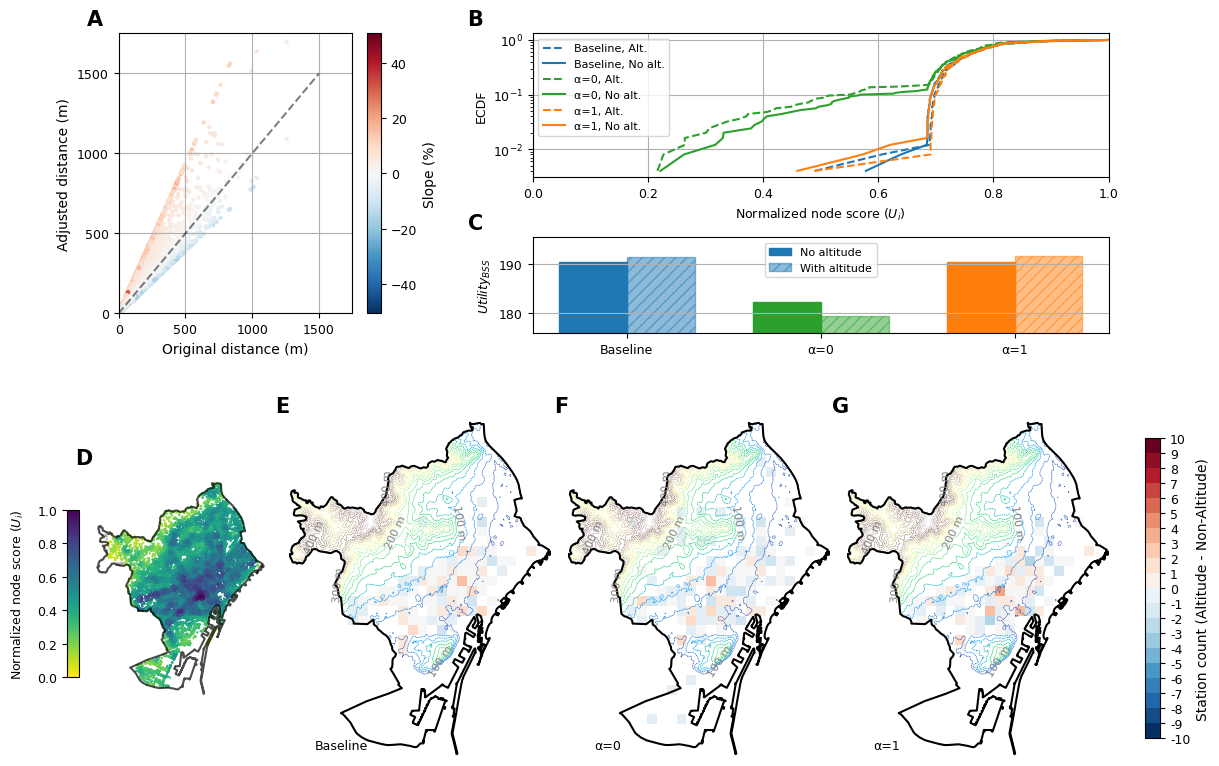

alpha S3
stations_data_dict dict_keys([0.0, 'S3', 1.0])
stations_data_alt_dict dict_keys(['S3', 0.0, 1.0])
alpha 0.0
stations_data_dict dict_keys([0.0, 'S3', 1.0])
stations_data_alt_dict dict_keys(['S3', 0.0, 1.0])
alpha 1.0
stations_data_dict dict_keys([0.0, 'S3', 1.0])
stations_data_alt_dict dict_keys(['S3', 0.0, 1.0])


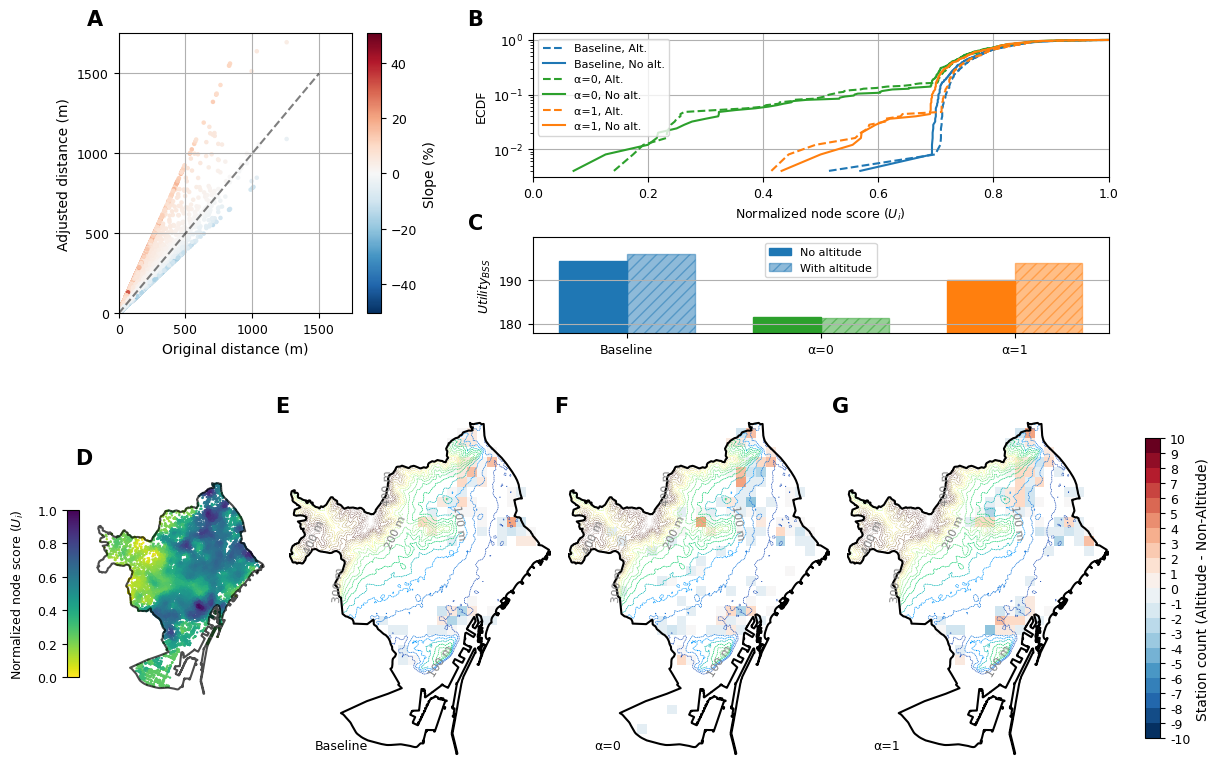

In [21]:
fontsize = 9
diff_cmap = plt.cm.RdBu_r
color_dict = {
    '0.0': '#2ca02c',    # Default matplotlib green  
    '1.0': '#ff7f0e',    # Default matplotlib orange
}
ticks_spacing_altitude_comparison = 500
altitude_granularity = 25
grid_size = 500

# Plot for each scenario
alpha_order = ['S1', '0.0', '1.0']

for scenario in ['s1', 's2', 's3']:
    alpha_order[0] = scenario.upper()
    color_dict[scenario] = '#1f77b4'  # Add scenario color
    
    # Create figure
    fig, axes_first_row, axes_second_row = create_figure()
    ax_scatter, ax_ecdf, ax_bar = axes_first_row
    ax_map_node_scores, ax_map_scenario, ax_map_alpha_0, ax_map_alpha_1 = axes_second_row

    # ROW 1: Process data
    ecdfs, totals = process_scenario_data(scenario, df_results, df_results_alt, 
                                        df_weights, weights_dict)
    
    # ROW 1: Create plots
    plot_distance_comparison(edges_gdf, ax_scatter, ticks_spacing_altitude_comparison, fontsize)
    ax_scatter.set_title('$\mathbf{A}$', x=-0.1, y=1.0, fontsize=15)

    create_ecdf_plot(ax_ecdf, ecdfs, color_dict, fontsize)
    ax_ecdf.set_title('$\mathbf{B}$', x=-0.1, y=1.0, fontsize=15)

    create_bar_plot(ax_bar, totals, color_dict, fontsize)
    ax_bar.set_title('$\mathbf{C}$', x=-0.1, y=1.0, fontsize=15)

    # ROW 2: Plot node scores and colorbar on first map
    hv.plot_nodes_on_map(df_weights, scenario.lower(), ax_map_node_scores, city_boundary, 
                        show_colorbar=False, show_norm_raw_vals=False, ctx_background=False)
    ax_map_node_scores.set_title('$\mathbf{D}$', x=-0.025, y=1.0, fontsize=15)

    # ROW 2: Get stations data
    stations_data_dict = filter_stations_data(df_results, df_weights, weights_dict, scenario)
    stations_data_alt_dict = filter_stations_data(df_results_alt, df_weights, weights_dict, scenario)

    # ROW 2: Set subplot titles
    ax_map_scenario.set_title('$\mathbf{E}$', x=-0.025, y=1.0, fontsize=15)
    ax_map_alpha_0.set_title('$\mathbf{F}$', x=-0.025, y=1.0, fontsize=15)
    ax_map_alpha_1.set_title('$\mathbf{G}$', x=-0.025, y=1.0, fontsize=15)

    # ROW 2: Setup difference colormap and calculate max difference
    max_diff_global = 0
    for alpha in alpha_order:
        alpha = float(alpha) if alpha not in ['S1', 'S2', 'S3'] else alpha
        if alpha in stations_data_dict and alpha in stations_data_alt_dict:
            grid_non_alt = hv.create_grid_cells_and_count_points(city_boundary, stations_data_dict[alpha], grid_size)
            grid_alt = hv.create_grid_cells_and_count_points(city_boundary, stations_data_alt_dict[alpha], grid_size)
            
            grid_non_alt = grid_non_alt.set_index(grid_non_alt.geometry.apply(lambda x: x.wkt))
            grid_alt = grid_alt.set_index(grid_alt.geometry.apply(lambda x: x.wkt))
            
            all_geometries = set(grid_non_alt.index) | set(grid_alt.index)
            
            for geom in all_geometries:
                if geom not in grid_non_alt.index:
                    grid_non_alt.loc[geom, 'n_points'] = 0
                if geom not in grid_alt.index:
                    grid_alt.loc[geom, 'n_points'] = 0
            
            diff = grid_alt['n_points'].values - grid_non_alt['n_points'].values
            max_diff_global = max(max_diff_global, abs(diff).max())

    # Plot differences for each alpha
    for col, alpha in enumerate(alpha_order):
        alpha = float(alpha) if alpha not in ['S1', 'S2', 'S3'] else alpha
        if col == 0:
            plot_altitude_contours(ax_map_scenario, lons, lats, alts, city_boundary,
                                background_map=False, altitude_granularity=altitude_granularity)
            plot_station_differences(ax_map_scenario, stations_data_dict, stations_data_alt_dict,
                                alpha, city_boundary, grid_size, max_diff_global, diff_cmap)
            ax_map_scenario.text(0.1, 0.02, "Baseline", transform=ax_map_scenario.transAxes, fontsize=fontsize)
        elif col == 1:
            plot_altitude_contours(ax_map_alpha_0, lons, lats, alts, city_boundary,
                                background_map=False, altitude_granularity=altitude_granularity)
            plot_station_differences(ax_map_alpha_0, stations_data_dict, stations_data_alt_dict,
                                alpha, city_boundary, grid_size, max_diff_global, diff_cmap)
            ax_map_alpha_0.text(0.1, 0.02, f"α=0", transform=ax_map_alpha_0.transAxes, fontsize=fontsize)
        elif col == 2:
            plot_altitude_contours(ax_map_alpha_1, lons, lats, alts, city_boundary,
                                background_map=False, altitude_granularity=altitude_granularity)
            plot_station_differences(ax_map_alpha_1, stations_data_dict, stations_data_alt_dict,
                                alpha, city_boundary, grid_size, max_diff_global, diff_cmap)
            ax_map_alpha_1.text(0.1, 0.02, f"α=1", transform=ax_map_alpha_1.transAxes, fontsize=fontsize)

    create_difference_colorbar(fig, max_diff_global, diff_cmap, fontsize)
    create_node_scores_colorbar(ax_map_scenario, fontsize)
    
    fig.savefig(
        f'{RESULTS_DIR}/altitude_comparison_{scenario}.png', dpi=300, bbox_inches='tight')
    plt.show()
    del color_dict[scenario]  # Clean up for next iteration